In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

In [2]:
df = pd.read_csv(r'Dataset/ecom.csv')
df.head()

,Cust_ID,Gender,Orders,Jordan,Gatorade,Samsung,Asus,Udis,Mondelez International,Wrangler,...,LG,Dior,Scabal,Tommy Hilfiger,Hollister,Forever 21,Colavita,Microsoft,Jiffy mix,Kraft
0,1,M,7,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,F,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,3,M,7,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,F,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,NaN,10,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1,1


In [3]:
df.shape

(30000, 38)

In [4]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 38 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Cust_ID                 30000 non-null  int64 
 1   Gender                  27276 non-null  object
 2   Orders                  30000 non-null  int64 
 3   Jordan                  30000 non-null  int64 
 4   Gatorade                30000 non-null  int64 
 5   Samsung                 30000 non-null  int64 
 6   Asus                    30000 non-null  int64 
 7   Udis                    30000 non-null  int64 
 8   Mondelez International  30000 non-null  int64 
 9   Wrangler                30000 non-null  int64 
 10  Vans                    30000 non-null  int64 
 11  Fila                    30000 non-null  int64 
 12  Brooks                  30000 non-null  int64 
 13  H&M                     30000 non-null  int64 
 14  Dairy Queen             30000 non-null  int64 
 15  Fe

In [5]:
df.duplicated().sum()

0

In [6]:
df.isnull().sum()

Cust_ID                      0
Gender                    2724
Orders                       0
Jordan                       0
Gatorade                     0
Samsung                      0
Asus                         0
Udis                         0
Mondelez International       0
Wrangler                     0
Vans                         0
Fila                         0
Brooks                       0
H&M                          0
Dairy Queen                  0
Fendi                        0
Hewlett Packard              0
Pladis                       0
Asics                        0
Siemens                      0
J.M. Smucker                 0
Pop Chips                    0
Juniper                      0
Huawei                       0
Compaq                       0
IBM                          0
Burberry                     0
Mi                           0
LG                           0
Dior                         0
Scabal                       0
Tommy Hilfiger               0
Holliste

In [7]:
(df.isnull().sum()['Gender'])/len(df) * 100

9.08

9% missing values means something. But still we can't fill values for gender without collecting them from users... Also, it is most probably missing because of user not providing the data... So, this would come under MCAR and here we can't fill using any sampling, bw fill or fw fill mechanisms....Also creating new category might confuse the model and potentially could create another new cluster.... So, removing those instances would be appropriate as the size of dataset is considerably big and also even after dropping those we would have more than enough data to analyse things...

Also Cust_ID is unnecessary for model building so dropping it...

In [8]:
df.dropna(inplace=True)

In [9]:
df.drop(columns = ['Cust_ID'], inplace = True)

Now as model won't process categorical variables, encoding the cat to num variable

In [10]:
df_encoded = pd.get_dummies(df, columns=['Gender'], prefix=['Gender'], drop_first=True).astype(int)

In [11]:
df_encoded.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 27276 entries, 0 to 29999
Data columns (total 37 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   Orders                  27276 non-null  int32
 1   Jordan                  27276 non-null  int32
 2   Gatorade                27276 non-null  int32
 3   Samsung                 27276 non-null  int32
 4   Asus                    27276 non-null  int32
 5   Udis                    27276 non-null  int32
 6   Mondelez International  27276 non-null  int32
 7   Wrangler                27276 non-null  int32
 8   Vans                    27276 non-null  int32
 9   Fila                    27276 non-null  int32
 10  Brooks                  27276 non-null  int32
 11  H&M                     27276 non-null  int32
 12  Dairy Queen             27276 non-null  int32
 13  Fendi                   27276 non-null  int32
 14  Hewlett Packard         27276 non-null  int32
 15  Pladis                  

In [12]:
df_encoded.nunique()

Orders                    13
Jordan                    16
Gatorade                  13
Samsung                   20
Asus                      17
Udis                      13
Mondelez International    13
Wrangler                  10
Vans                      16
Fila                      14
Brooks                    10
H&M                       16
Dairy Queen               24
Fendi                     14
Hewlett Packard           10
Pladis                    11
Asics                     25
Siemens                   11
J.M. Smucker              26
Pop Chips                 17
Juniper                   28
Huawei                    16
Compaq                    19
IBM                        9
Burberry                  21
Mi                         9
LG                        13
Dior                      12
Scabal                    11
Tommy Hilfiger             9
Hollister                 10
Forever 21                 9
Colavita                  15
Microsoft                 13
Jiffy mix     

The entire dataset seems to be discrete and of int dtype as every feature has just the no. of search made by a specified user with any particular brand name as thier values...

In [13]:
def count_outliers(df):
    outliers = {}
    for col in df.select_dtypes(include='number').columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        upper_bound = q3 + (1.5 * iqr)
        lower_bound = q1 - (1.5 * iqr)
        outliers[col] = round(((len(df[(df[col] > upper_bound) | (df[col] < lower_bound)])) / len(df) * 100), 2)
    return outliers

In [14]:
outliers_percent = count_outliers(df_encoded)
print(sorted(list(outliers_percent.values())))

[0.0, 2.03, 2.49, 3.12, 3.98, 4.53, 4.76, 5.35, 5.59, 6.23, 6.46, 6.58, 6.66, 6.78, 6.93, 7.86, 8.18, 8.34, 8.36, 9.28, 10.09, 10.46, 10.49, 10.57, 10.93, 11.48, 11.91, 13.58, 14.73, 15.11, 16.6, 17.15, 17.25, 18.23, 19.15, 21.21, 23.34]


Clustering Algorithm is so sensitive to outliers and scaling as well would deflect the analysis in wrong direction (Have observed it through trial and error).... So, we would do clipping which would cap the value to specified quantile and preserve the instances without removing them outright.... This can be considered like kinda binning the outliers and putting them together under single umbrella value....

In [15]:
def outlier_capping(x):
    x = x.clip(upper=x.quantile(0.75))
    return x

In [16]:
df_new = df_encoded.apply(lambda x : outlier_capping(x))
df_new.shape

(27276, 37)

In [17]:
X = df_new

{'1 Cluster': 234541.26008211987, '2 Clusters': 52114.779098403116, '3 Clusters': 30254.82814081334, '4 Clusters': 24108.281639129862, '5 Clusters': 21385.84865334413, '6 Clusters': 19318.516762578758, '7 Clusters': 18031.962145394784, '8 Clusters': 18203.963328191025, '9 Clusters': 16834.302585499467, '10 Clusters': 14921.462324423592}


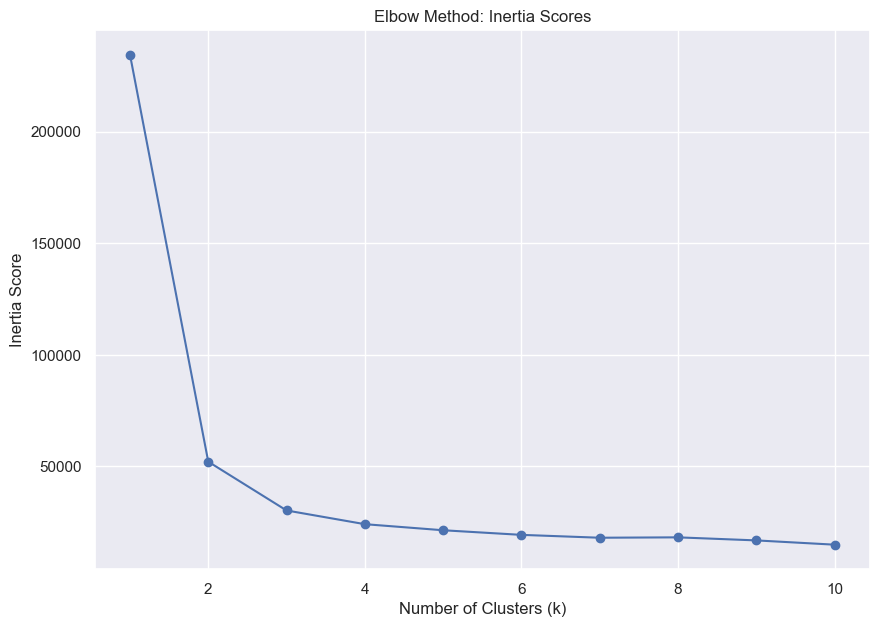

In [18]:
k_values = range(1, 11)
inertia_scores = []
cluster_mapping = {}

for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42)
    kmeans.fit(X)
    
    inertia_score = kmeans.inertia_
    inertia_scores.append(inertia_score)
    
    cluster_mapping[f'{k} Cluster' if k == 1 else f'{k} Clusters'] = inertia_score

print(cluster_mapping)

sns.set_theme()
plt.figure(figsize=(10, 7))
plt.plot(k_values, inertia_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia Score')
plt.title('Elbow Method: Inertia Scores')
plt.show()

As we can see, 3 clusters would be the most appropriate one. But let's check other metrics and confirm with them...

{'2 Clusters': 0.6388737675391719, '3 Clusters': 0.5464197192741068, '4 Clusters': 0.4663798853985795, '5 Clusters': 0.41155391558288357, '6 Clusters': 0.3383642535741, '7 Clusters': 0.33809399945758933, '8 Clusters': 0.3205374401481015, '9 Clusters': 0.3456654960248933, '10 Clusters': 0.3834013263165915}


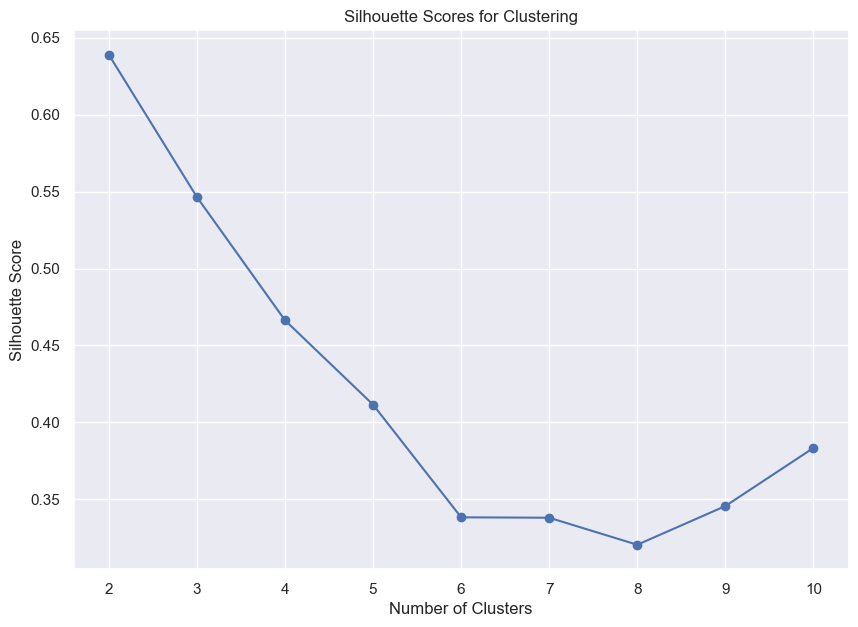

In [19]:
k_values = range(2, 11)
silhouette_scores = []
cluster_mapping = {}

for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42)
    kmeans.fit(X)
    labels = kmeans.labels_

    silhouette_avg = silhouette_score(X, labels)
    silhouette_scores.append(silhouette_avg)

    cluster_mapping[f'{k} Clusters'] = silhouette_avg

print(cluster_mapping)

sns.set_theme()
plt.figure(figsize=(10, 7))
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Clustering')
plt.show()

Higher silhouette score denotes good cluster... So, 2 should be ideal when you consider the silhoutte score plot...

{'2 Clusters': 95471.95495073049, '3 Clusters': 92076.27675827796, '4 Clusters': 79349.33278671128, '5 Clusters': 67953.36158152962, '6 Clusters': 60761.64420337837, '7 Clusters': 54569.69498412312, '8 Clusters': 46293.57199021804, '9 Clusters': 44078.27098799541, '10 Clusters': 44590.15905684861}


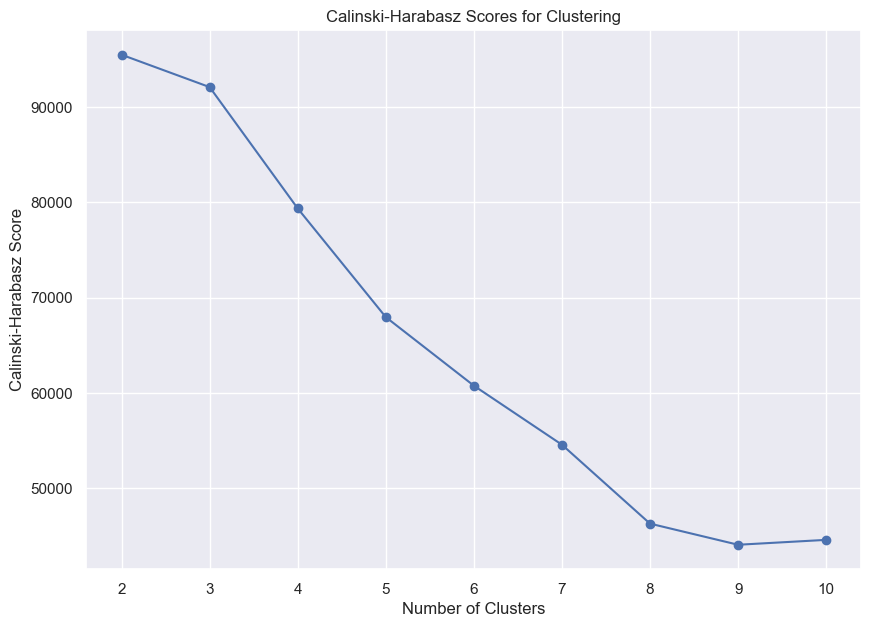

In [20]:
k_values = range(2, 11)
calinski_scores = []
cluster_mapping = {}

for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42)
    kmeans.fit(X)
    labels = kmeans.labels_

    calinski_score = calinski_harabasz_score(X, labels)
    calinski_scores.append(calinski_score)

    cluster_mapping[f'{k} Clusters'] = calinski_score

print(cluster_mapping)

sns.set_theme()
plt.figure(figsize=(10, 7))
plt.plot(k_values, calinski_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Calinski-Harabasz Score')
plt.title('Calinski-Harabasz Scores for Clustering')
plt.show()

Higher Calinski Score denotes good cluster... Hence 2 should be the right one...

{'2 Clusters': 0.5055377800251302, '3 Clusters': 0.6997392748673362, '4 Clusters': 0.9545400530215613, '5 Clusters': 1.2260781932309759, '6 Clusters': 1.3885651129384031, '7 Clusters': 1.3636313683953012, '8 Clusters': 1.5232082068894226, '9 Clusters': 1.4104116831130282, '10 Clusters': 1.3392144056007624}


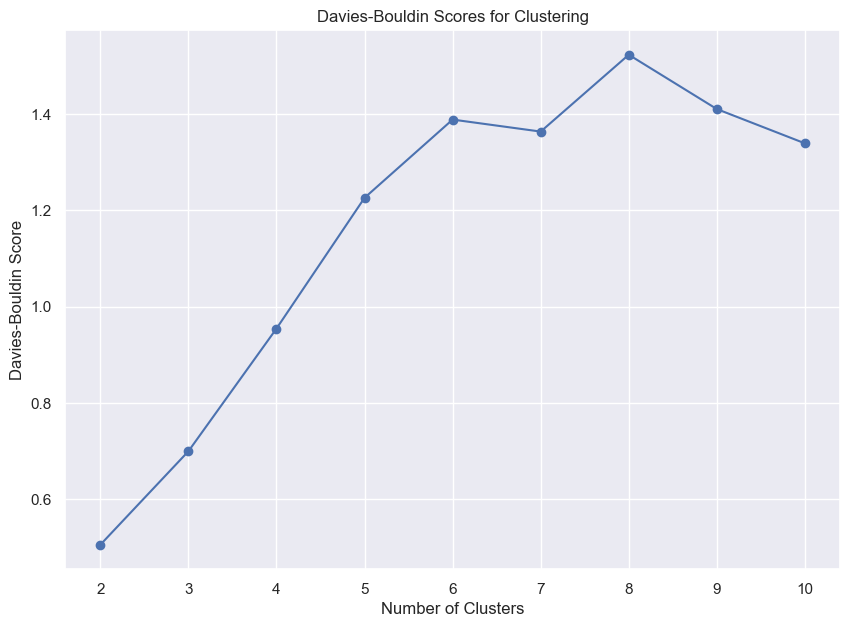

In [21]:
k_values = range(2, 11)
davies_scores = []
cluster_mapping = {}

for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42)
    kmeans.fit(X)
    labels = kmeans.labels_

    davies_score = davies_bouldin_score(X, labels)
    davies_scores.append(davies_score)
    
    cluster_mapping[f'{k} Clusters'] = davies_score

print(cluster_mapping)
    
sns.set_theme()
plt.figure(figsize=(10, 7))
plt.plot(k_values, davies_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Score')
plt.title('Davies-Bouldin Scores for Clustering')
plt.show()

Lower Davies Score denotes good cluster... This as well points towards 2 clusters...

In [22]:
kmeans = KMeans(n_clusters=2, n_init='auto', random_state=42)
y = kmeans.fit_predict(X)

In [23]:
segmented_df = df
segmented_df['Cluster'] = y

In [24]:
segmented_df['Cluster'] = np.where(segmented_df['Cluster'] == 0, 'Cluster 1', 'Cluster 2')

<Axes: ylabel='count'>

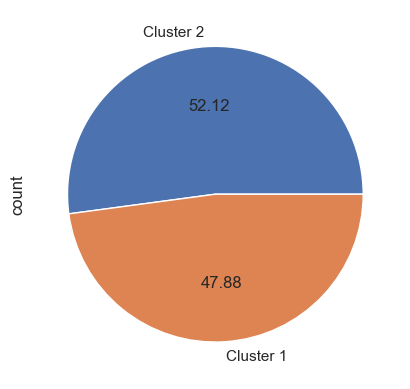

In [25]:
segmented_df['Cluster'].value_counts().plot.pie(autopct = '%.2f')

In [26]:
segmented_df['Total_Search'] = segmented_df.iloc[:,1:-3].sum(axis=1)
segmented_df.head()

,Gender,Orders,Jordan,Gatorade,Samsung,Asus,Udis,Mondelez International,Wrangler,Vans,...,Scabal,Tommy Hilfiger,Hollister,Forever 21,Colavita,Microsoft,Jiffy mix,Kraft,Cluster,Total_Search
0,M,7,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,Cluster 2,9
1,F,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Cluster 1,18
2,M,7,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,Cluster 2,12
3,F,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Cluster 1,2
5,F,4,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,Cluster 2,10


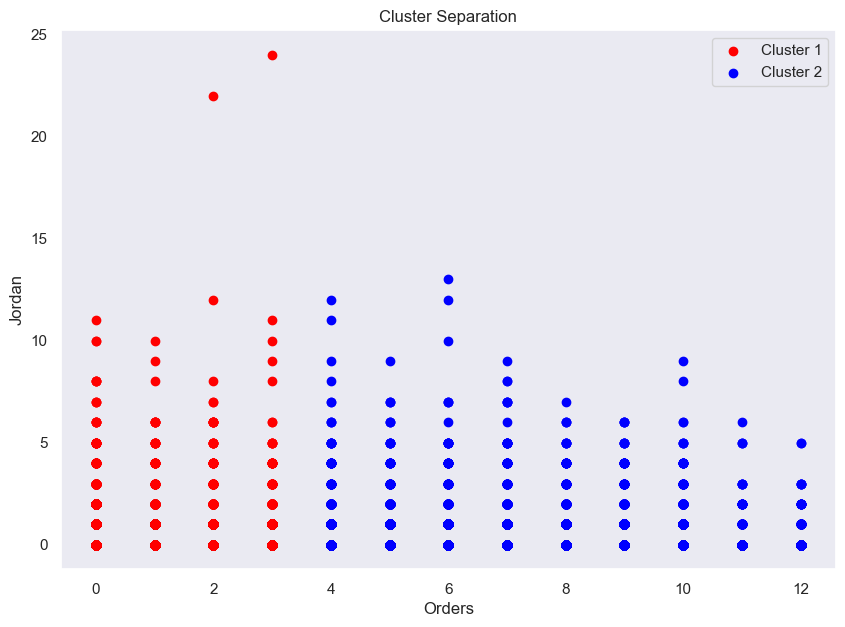

In [27]:
plt.figure(figsize=(10, 7))

plt.scatter(segmented_df.loc[segmented_df['Cluster'] == 'Cluster 1', 'Orders'],
            segmented_df.loc[segmented_df['Cluster'] == 'Cluster 1', 'Jordan'],
            color='red', label='Cluster 1')
plt.scatter(segmented_df.loc[segmented_df['Cluster'] == 'Cluster 2', 'Orders'],
            segmented_df.loc[segmented_df['Cluster'] == 'Cluster 2', 'Jordan'],
            color='blue', label='Cluster 2')

sns.set_theme()
plt.xlabel('Orders')
plt.ylabel('Jordan')
plt.title('Cluster Separation')
plt.legend()
plt.grid(False)
plt.show()

Clusters look well segmented and as the values are discrete, the plot appears in a linear fashion...

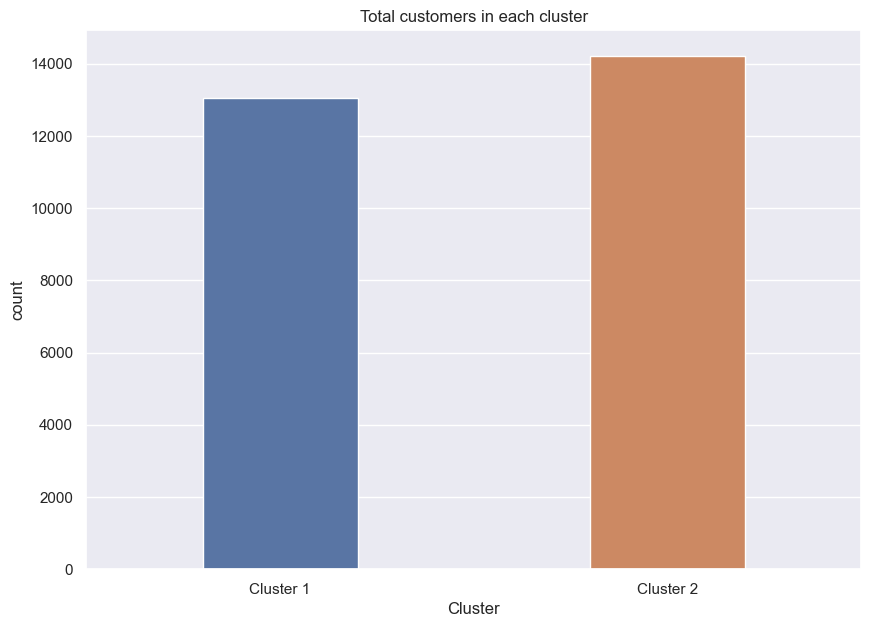

In [28]:
plt.figure(figsize=(10, 7))
sns.countplot(data = segmented_df, x='Cluster', order=['Cluster 1', 'Cluster 2'], width=0.4)
plt.title('Total customers in each cluster')
plt.show()

As we have already seen in the pie chart Cluster 2 has slightly more no. of customers

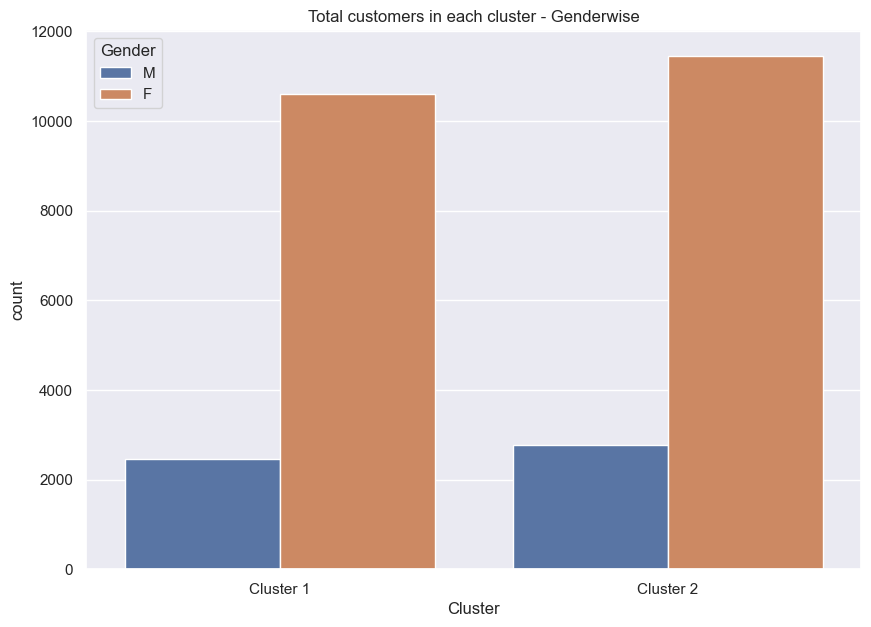

In [29]:
plt.figure(figsize=(10, 7))
sns.countplot(data = segmented_df, x='Cluster', hue = 'Gender', order=['Cluster 1', 'Cluster 2'])
plt.title('Total customers in each cluster - Genderwise')
plt.show()

As in original dataset there was imbalance in gender data, the no. of female customers seem to be more than male ones in both clusters...

**Note that this is also a reflection of more no. of female customers in original dataset (80:20)**

Text(0.5, 1.0, 'Total searches in each cluster')

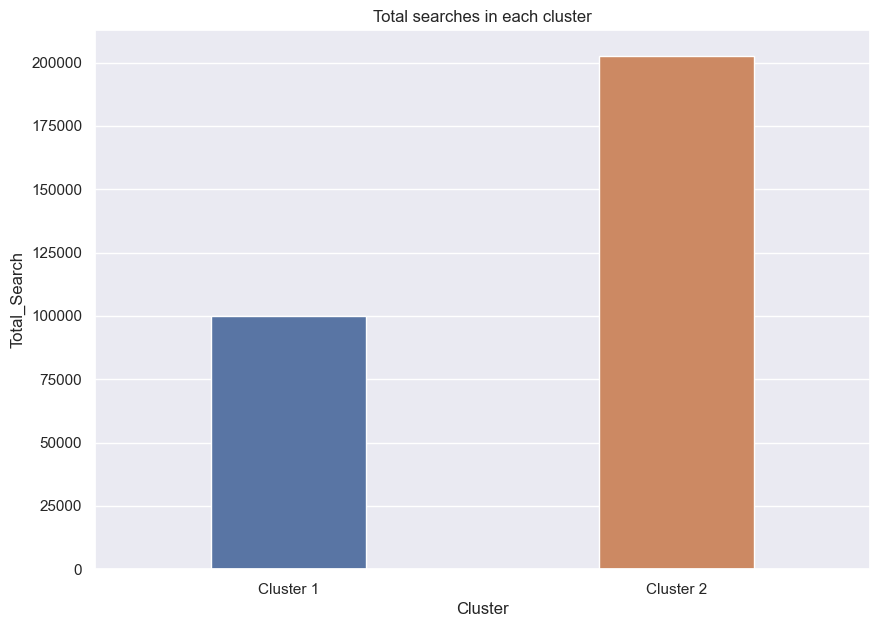

In [30]:
cluster_group = segmented_df.groupby(['Cluster'], as_index=False).sum()

plt.figure(figsize=(10, 7))
sns.barplot(data = cluster_group, x = 'Cluster' , y = 'Total_Search', order=['Cluster 1', 'Cluster 2'], errorbar=None, width=0.4)
plt.title('Total searches in each cluster')

Customers from Cluster 1 seem to have searched twice as much as those in Cluster 2 eventhough both clusters has almost equal proportion of customers in them...

Text(0.5, 1.0, 'Total searches in each cluster -  Genderwise')

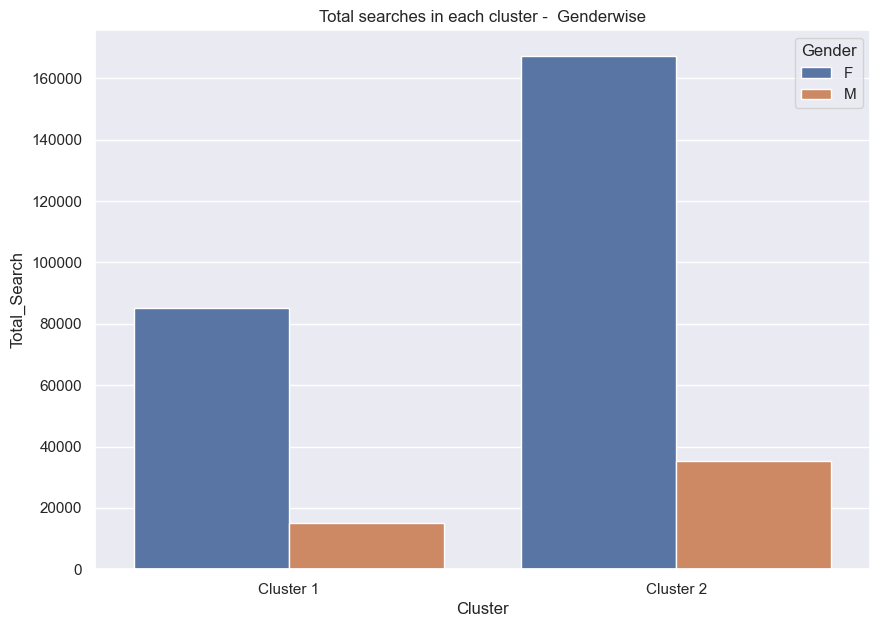

In [31]:
gender_group = segmented_df.groupby(['Cluster', 'Gender'], as_index=False).sum()

plt.figure(figsize=(10, 7))
sns.barplot(data = gender_group, x = 'Cluster' , y = 'Total_Search', hue = 'Gender', order=['Cluster 1', 'Cluster 2'], errorbar=None)
plt.title('Total searches in each cluster -  Genderwise')

In both clusters, female customers seem to have searched for different brands significantly higher no. of times than male customers...

**Note that this is also a reflection of more no. of female customers in original dataset (80:20)**

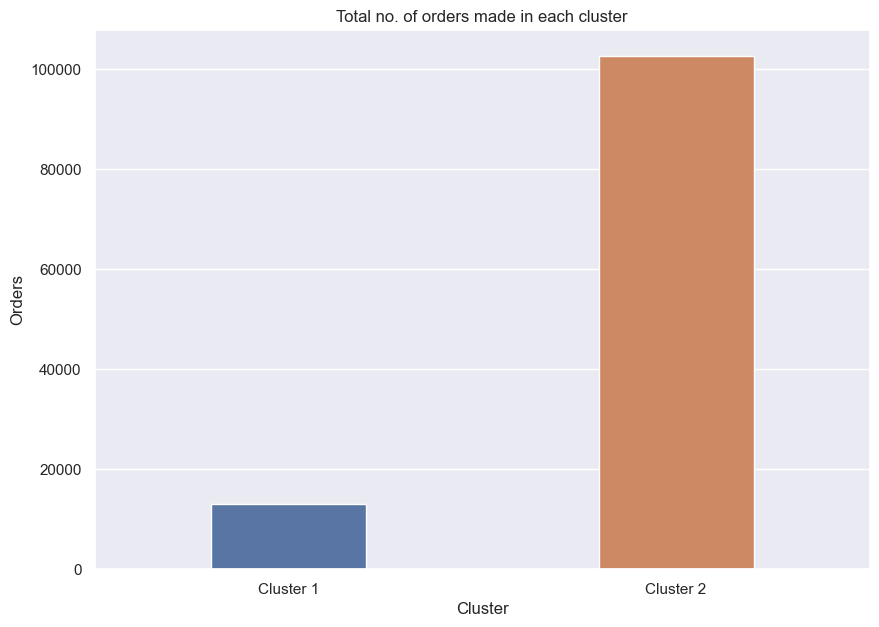

In [32]:
plt.figure(figsize=(10, 7))
sns.barplot(data=cluster_group, x='Cluster', y='Orders', order=['Cluster 1', 'Cluster 2'], errorbar=None, width=0.4)
plt.title('Total no. of orders made in each cluster')
plt.show()

Customers from cluster 1 has made significantly lesser no. of orders than customers from cluster 2 despite total no. of customers is almost equal in both clusters and eventhough customers from cluster 1 has made 1 Lakh + searches, they have made just around 15k orders... While at the same time customers from cluster 2 have a probability of 50% in making an order when they do a search... So, these customers are much engaging than those in cluster 1...

This shows a clear distinction between cluster 1 and cluster 2...

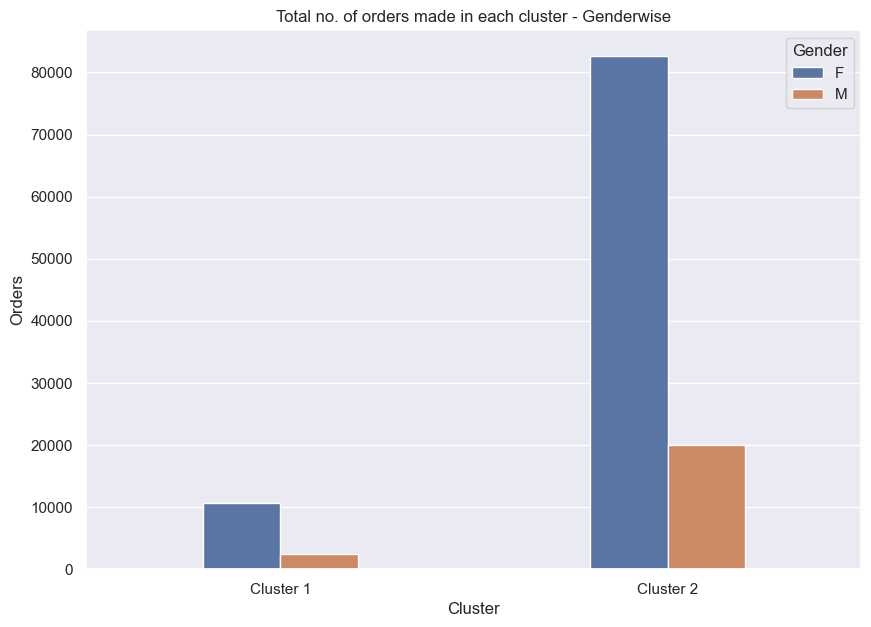

In [33]:
plt.figure(figsize=(10, 7))
sns.barplot(data=gender_group, x='Cluster', y='Orders', hue='Gender', order=['Cluster 1', 'Cluster 2'], errorbar=None, width=0.4)
plt.title('Total no. of orders made in each cluster - Genderwise')
plt.show()

In both cases, female customers has made more no. of orders than male counterparts... 

**Note that this is also a reflection of more no. of female customers in original dataset (80:20)**